In [1]:
import wrds
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import os
import pickle
warnings.filterwarnings('ignore')


# First draft - dispersion trade

require: 
1. option_name data for the names of tickers 
2. option_data for the option data and 
3. secutiry price from secprd2023

## Get secid of Indices and corresponding ETF


In [2]:
# Establish WRDS connection
db = wrds.Connection(wrds_username='changjulian17')

# Create cache directory if it doesn't exist
cache_dir = '../cache'
os.makedirs(cache_dir, exist_ok=True)

# Check if cached data exists
option_name_cache = f'{cache_dir}/option_name.csv'

if os.path.exists(option_name_cache):
    print("Loading cached option_name data...")
    option_name = pd.read_csv(option_name_cache)
else:
    print("Fetching option_name data from WRDS...")
    
    query = """
    SELECT 
        *
    FROM optionm.secnmd
    """
    
    option_name = db.raw_sql(query)
    db.close()
    
    # Cache the results
    option_name.to_csv(option_name_cache, index=False)
    print(f"Cached option_name data to {option_name_cache}")

print(f"Retrieved {len(option_name)} option records")
print(option_name.head())
option_name[option_name['ticker'] == 'SPY']

Loading library list...
Done
Loading cached option_name data...
Retrieved 265203 option records
    secid effect_date     cusip ticker class                      issuer  \
0  5001.0  1996-01-02  00078110  ABSIE   NaN          ABS INDUSTRIES INC   
1  5001.0  2007-03-08  00078110   ZZZZ   NaN                ABS INDS INC   
2  5002.0  1996-01-01  00103010  AELNA   NaN       AEL INDUSTRIES - CI A   
3  5003.0  1996-01-01  00103810   AFAP   NaN  AFA PROTECTIVE SYSTEMS INC   
4  5003.0  1999-07-08  00103810  AFAPE   NaN  AFA PROTECTIVE SYSTEMS INC   

  issue     sic  
0   NaN     NaN  
1   COM  3462.0  
2   NaN     NaN  
3   NaN     NaN  
4   NaN     NaN  


,secid,effect_date,cusip,ticker,class,issuer,issue,sic
5563,7571.0,1996-10-28,81750M10,SPY,NaN,SERENPET INC,NaN,NaN
10623,100155.0,2009-11-02,32299W10,SPY,I,SPDR TRUST SERIES 1,INTRADAY,9999.0
71921,109820.0,1996-01-02,78462F10,SPY,NaN,SPDR TR,UNIT SER 1,NaN
71922,109820.0,2000-11-28,78462F10,SPY,NaN,SPDR TR,UNIT SER 1,6726.0
71923,109820.0,2010-01-28,78462F10,SPY,NaN,SPDR S&P 500 ETF TR,UNIT SER 1 S&P,6726.0
71924,109820.0,2010-07-08,78462F10,SPY,NaN,SPDR S&P 500 ETF TR,TR UNIT,6726.0
71925,109820.0,2017-12-26,78462F10,SPY,NaN,SPDR S&P 500 ETF TR,TR UNIT,6733.0
71926,109820.0,2020-07-27,78462F10,SPY,NaN,SSGA ACTIVE TRUST,SSGA SPDR S&P 500,NaN
71927,109820.0,2021-02-25,78462F10,SPY,NaN,SSGA ACTIVE TRUST,SPDR S&P 500 ETF TRU,NaN
71928,109820.0,2021-03-01,78462F10,SPY,NaN,SSGA ACTIVE TRUST,S&P 500 ETF TRUST ET,NaN


In [3]:
# 1. Get secids for target tickers from secnmd with issuer filtering
target_tickers = ['SPY', 'XLK', 'XLY', 'XLF', 'XLV']
target_issuers = ['SPDR S&P 500 ETF TR', 'SECTOR SPDR TR', 
                  'SELECT SECTOR SPDR TR']

# Filter secnmd for target tickers AND issuers
target_securities = option_name[
    (option_name['ticker'].isin(target_tickers)) &
    (option_name['issuer'].isin(target_issuers))
]

target_secids = target_securities['secid'].tolist()

# print(f"Found {len(target_secids)} secids for target tickers and issuers:")
target_securities = target_securities[['secid', 'ticker']].drop_duplicates()
secid_list = target_securities['secid'].tolist()
secid_list

[109820.0, 110008.0, 110010.0, 110012.0, 110014.0]

## Get Option data for short listed secid

In [16]:
# Convert secids to string format for SQL IN clause
secid_list_str = ','.join([f"'{secid}'" for secid in secid_list])

# Cache option data
option_data_cache = f'{cache_dir}/filtered_option_data.pkl'

if os.path.exists(option_data_cache):
    print("Loading cached option data...")
    with open(option_data_cache, 'rb') as f:
        filtered_option_data = pickle.load(f)
else:
    print("Fetching option data from WRDS...")
    
    query = f"""
    SELECT 
        *
    FROM optionm.opprcd2023
    WHERE secid IN ({secid_list_str})
        AND date >= '2023-01-01'
        AND date <= '2023-12-31'
    ORDER BY date, secid, strike_price, cp_flag
    """
    
    filtered_option_data = db.raw_sql(query)
    db.close()
    
    # Cache the results
    with open(option_data_cache, 'wb') as f:
        pickle.dump(filtered_option_data, f)
    print(f"Cached option data to {option_data_cache}")

print(f"Retrieved {len(filtered_option_data)} option records for target secids")
print(filtered_option_data.head())

Loading cached option data...
Retrieved 2394422 option records for target secids
      secid        date             symbol symbol_flag      exdate  \
0  109820.0  2023-01-03  SPY 241220C120000           1  2024-12-20   
1  109820.0  2023-01-03  SPY 241220P120000           1  2024-12-20   
2  109820.0  2023-01-03  SPY 241220C130000           1  2024-12-20   
3  109820.0  2023-01-03  SPY 241220P130000           1  2024-12-20   
4  109820.0  2023-01-03  SPY 241220C140000           1  2024-12-20   

    last_date cp_flag  strike_price  best_bid  best_offer  ...     theta  \
0  2022-12-19       C      120000.0     260.5       265.5  ... -8.084044   
1  2023-01-03       P      120000.0      0.99        1.16  ... -1.457403   
2  2022-10-17       C      130000.0     251.5       256.5  ... -9.233222   
3  2022-12-29       P      130000.0       0.0        1.35  ... -0.995745   
4        <NA>       C      140000.0     242.5       247.5  ... -10.00525   

      optionid  cfadj  am_settlement  con

## Get the ETF OCHL (Open Close High Low)

In [5]:
# Cache security price data
security_data_cache = f'{cache_dir}/security_data.csv'

if os.path.exists(security_data_cache):
    print("Loading cached security price data...")
    security_data = pd.read_csv(security_data_cache, parse_dates=['date'])
else:
    print("Fetching security price data from WRDS...")
    db = wrds.Connection(wrds_username='changjulian17')
    
    query = f"""
    SELECT 
        *
    FROM optionm.secprd2023
    WHERE secid IN ({secid_list_str})
        AND date >= '2023-01-01'
        AND date <= '2023-12-31'
    """
    
    security_data = db.raw_sql(query)
    db.close()
    
    # Cache the results
    security_data.to_csv(security_data_cache, index=False)
    print(f"Cached security data to {security_data_cache}")

print(f"Retrieved {len(security_data)} security price records")
print(security_data.head())

Loading cached security price data...
Retrieved 835 security price records
      secid       date       low    high   close       volume    return  \
0  109820.0 2023-01-03  377.8310  386.43  380.82   74850731.0 -0.004210   
1  109820.0 2023-01-04  380.0000  385.88  383.76   85934098.0  0.007720   
2  109820.0 2023-01-05  378.7600  381.84  379.38   76970456.0 -0.011413   
3  109820.0 2023-01-06  379.4127  389.25  388.08  104189603.0  0.022932   
4  109820.0 2023-01-09  387.6700  393.70  387.86   73978071.0 -0.000567   

   cfadj    open    cfret    shrout  
0    1.0  384.37  1.62005  932632.0  
1    1.0  383.18  1.62005  932632.0  
2    1.0  381.72  1.62005  927282.0  
3    1.0  382.61  1.62005  931982.0  
4    1.0  390.37  1.62005  929682.0  


In [6]:
security_data['secid'].unique()

array([109820., 110008., 110010., 110012., 110014.])

In [7]:
# Add ticker mapping to security data
secid_ticker_mapping = target_securities.set_index('secid')['ticker'].to_dict()
security_data['ticker'] = security_data['secid'].map(secid_ticker_mapping)

# Calculate average close price for each security
# ensure to only take mean dates for test period before 1 July 2023
cutoff_date = pd.to_datetime('2023-02-01')
security_data_before_july = security_data[security_data['date'] < cutoff_date]

avg_close_prices = security_data_before_july.groupby(['secid', 'ticker'])['close'].mean().reset_index()
avg_close_prices.columns = ['secid', 'ticker', 'avg_close']
avg_close_prices

,secid,ticker,avg_close
0,109820.0,SPY,394.6960
1,110008.0,XLV,134.1395
2,110010.0,XLY,138.3150
3,110012.0,XLF,35.5800
4,110014.0,XLK,130.0410


## Basic calculations 
assumed proportion (27 July 2025), estimated and scaled proportions:

| Sector                 | Ticker | Assumed Proportion | Estimated (%) | Scaled (%) |
| ---------------------- | ------ | ------------------ | ------------- | ---------- |
| Technology             | XLK    | 34.36%             | 30%           | 42.857%    |
| Financial Services     | XLF    | 13.67%             | 10%           | 14.2857%   |
| Consumer Cyclical      | XLY    | 10.54%             | 10%           | 14.2857%   |
| Communication Services | XLC    | 9.79%              | 10%           | 14.2857%   |
| Healthcare             | XLV    | 9.33%              | 10%           | 14.2857%   |

*won't be too exact since it is a snapshot and it should change over time too

show the market cap and implied notional for all components

SPY: 384.37\
XLK: 125.77\
XLV: 135.96\
XLY: 129.93\
XLF: 34.45

## Fundamental assumption
Volitility of S index is much lower than C component.
$$
{IV}_S \le \sum{{IV}_i}
$$
SPY should be represented by a proportionate constituents of sector ETF. Also so that the IV can be easily comparable i.e. 1 unit of SPY vol is comparable with one basket of C vol

$$
S_0 \times Q_0 = \sum{{C_i} \times Q_i} 
$$

Need to calculate delta as the scaling factor to get proportion of purchase of stocks.

Assumption
1. take only top 4 sectors of SPY and scale up to 100% of SPY give n by (scaled_weights)
2. fix the proportion of 4 sectors 


In [8]:
scaled_weights = {
    "SPY": 100,
    "XLK": 42.857,
    "XLF": 14.2857,
    "XLY": 14.2857,
    "XLC": 14.2857,
    "XLV": 14.2857
}

avg_close_prices['Scaled_Weight'] = avg_close_prices['ticker'].map(scaled_weights)
# Calculate relative position sizes
# coefficients = weights / prices * scaling_factor
vector = avg_close_prices['Scaled_Weight'].values / avg_close_prices['avg_close'].values * 20
vector_rounded = np.round(vector).astype(int)
# trial and error on the scaling factor to find a nice association
avg_close_prices['Vector (Scaled_Weight)'] = vector_rounded
avg_close_prices

,secid,ticker,avg_close,Scaled_Weight,Vector (Scaled_Weight)
0,109820.0,SPY,394.6960,100.0000,5
1,110008.0,XLV,134.1395,14.2857,2
2,110010.0,XLY,138.3150,14.2857,2
3,110012.0,XLF,35.5800,14.2857,8
4,110014.0,XLK,130.0410,42.8570,7


In [9]:
# Function to check if a date is the 3rd Friday of the month
def is_third_friday(date):
    return date.weekday() == 4 and 15 <= date.day <= 21

# Find ATM strikes for each option based on previous day's close
simplified_cols = ['secid', 'date', 'symbol', 'exdate', 
                     'cp_flag', 'strike_price', 'best_bid', 'best_offer',
                     'impl_volatility']

# 1. Prepare previous day's close for each secid/date
security_data_sorted = security_data.sort_values(['secid', 'date'])
security_data_sorted['prev_close'] = security_data_sorted.groupby('secid')['close'].shift(1)

# 2. Merge previous day's close into option data
filtered_option_data = filtered_option_data[simplified_cols]
# filter non-regular options
filtered_option_data['exdate'] = pd.to_datetime(filtered_option_data['exdate'])
filtered_option_data['date'] = pd.to_datetime(filtered_option_data['date'])

# Filter for rows where exdate is the 3rd Friday of the month and within the first/last exdate range
filtered_option_data = filtered_option_data[
    filtered_option_data['exdate'].apply(is_third_friday) &
    (filtered_option_data['exdate'] >= filtered_option_data['exdate'].min()) &
    (filtered_option_data['exdate'] <= filtered_option_data['exdate'].max())
]

filtered_option_data = filtered_option_data.merge(
    security_data_sorted[['secid', 'date', 'prev_close']],
    on=['secid', 'date'],
    how='left'
)

# Calculate the absolute difference between strike and previous close
filtered_option_data['abs_diff'] = np.abs(filtered_option_data['strike_price']/1000 - filtered_option_data['prev_close'])

# Find the ATM strike for each secid, date, cp_flag
atm_strike_idx = filtered_option_data.groupby(['secid', 'date', 'cp_flag'])['abs_diff'].idxmin().dropna()
atm_strikes = filtered_option_data.loc[atm_strike_idx, ['secid', 'date', 'cp_flag', 'strike_price']]
atm_strikes = atm_strikes.rename(columns={'strike_price': 'atm_strike_price'})

# Merge the ATM strike back to the original DataFrame
filtered_option_data = filtered_option_data.merge(
    atm_strikes,
    on=['secid', 'date', 'cp_flag'],
    how='left'
)

filtered_option_data = filtered_option_data.dropna(subset=['atm_strike_price'])
filtered_option_data

,secid,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,impl_volatility,prev_close,abs_diff,atm_strike_price
7098,109820.0,2023-01-04,SPY 241220C120000,2024-12-20,C,120000.0,258.31,268.3,<NA>,380.82,260.82,381000.0
7099,109820.0,2023-01-04,SPY 241220P120000,2024-12-20,P,120000.0,0.97,1.18,0.438464,380.82,260.82,381000.0
7100,109820.0,2023-01-04,SPY 241220C130000,2024-12-20,C,130000.0,249.48,259.47,<NA>,380.82,250.82,381000.0
7101,109820.0,2023-01-04,SPY 241220P130000,2024-12-20,P,130000.0,0.0,1.5,0.38874,380.82,250.82,381000.0
7102,109820.0,2023-01-04,SPY 241220C140000,2024-12-20,C,140000.0,240.49,250.49,0.319475,380.82,240.82,381000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1318439,110014.0,2023-08-31,XLK 240621C265000,2024-06-21,C,265000.0,0.0,2.57,0.265332,174.81,90.19,175000.0
1318440,110014.0,2023-08-31,XLK 250620P265000,2025-06-20,P,265000.0,87.75,90.25,<NA>,174.81,90.19,175000.0
1318441,110014.0,2023-08-31,XLK 250117P265000,2025-01-17,P,265000.0,86.85,91.45,<NA>,174.81,90.19,175000.0
1318442,110014.0,2023-08-31,XLK 240315P265000,2024-03-15,P,265000.0,87.4,90.75,<NA>,174.81,90.19,175000.0


In [15]:
np.sort(filtered_option_data['exdate'].unique())

array(['2023-01-20T00:00:00.000000000', '2023-02-17T00:00:00.000000000',
       '2023-03-17T00:00:00.000000000', '2023-04-21T00:00:00.000000000',
       '2023-05-19T00:00:00.000000000', '2023-06-16T00:00:00.000000000',
       '2023-07-21T00:00:00.000000000', '2023-08-18T00:00:00.000000000',
       '2023-09-15T00:00:00.000000000', '2023-10-20T00:00:00.000000000',
       '2023-11-17T00:00:00.000000000', '2023-12-15T00:00:00.000000000',
       '2024-01-19T00:00:00.000000000', '2024-03-15T00:00:00.000000000',
       '2024-04-19T00:00:00.000000000', '2024-06-21T00:00:00.000000000',
       '2024-09-20T00:00:00.000000000', '2024-12-20T00:00:00.000000000',
       '2025-01-17T00:00:00.000000000', '2025-03-21T00:00:00.000000000',
       '2025-06-20T00:00:00.000000000', '2025-12-19T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [19]:
filtered_option_data[filtered_option_data['secid'] ==  110014.0]['exdate'].unique()


<StringArray>
['2023-01-20', '2023-09-15', '2024-01-19', '2023-03-17', '2023-06-16',
 '2025-01-17', '2024-06-21', '2023-01-06', '2023-01-13', '2023-01-27',
 '2023-02-03', '2023-02-17', '2023-02-10', '2023-04-21', '2023-02-24',
 '2023-03-03', '2023-03-10', '2023-03-24', '2023-03-31', '2023-04-06',
 '2023-04-14', '2023-04-28', '2023-05-19', '2023-05-05', '2023-05-12',
 '2023-05-26', '2023-06-02', '2023-12-15', '2023-06-09', '2023-06-23',
 '2023-06-30', '2025-06-20', '2023-07-21', '2023-07-07', '2023-07-14',
 '2023-07-28', '2023-08-18', '2023-08-04', '2023-08-11', '2023-08-25',
 '2023-09-01', '2024-03-15', '2023-09-08', '2023-09-22', '2023-09-29',
 '2023-10-20', '2023-10-06', '2023-10-13']
Length: 48, dtype: string

179.3574531835206

In [ ]:
filtered_option_data.columns

Index(['secid', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date',
       'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'optionid', 'cfadj', 'am_settlement', 'contract_size', 'ss_flag',
       'forward_price', 'expiry_indicator', 'root', 'suffix', 'prev_close',
       'abs_diff', 'atm_strike_price'],
      dtype='object')

In [ ]:
filtered_option_data.suffix.describe()

count       0
unique      0
top       NaN
freq      NaN
Name: suffix, dtype: object

In [ ]:
filtered_option_data.open_interest.describe()

count      2394422.0
mean     1791.666293
std      7165.172413
min              0.0
25%              0.0
50%             20.0
75%            516.0
max         326149.0
Name: open_interest, dtype: Float64

In [ ]:
# Add ticker mapping to atm_options
atm_options['ticker'] = atm_options['secid'].map(secid_ticker_mapping)

# Create pivot table to get IV for each ticker by date
iv_pivot = atm_options.pivot_table(
    index='date', 
    columns='ticker', 
    values='impl_volatility', 
    aggfunc='mean'  # In case there are both calls and puts, take average
)

# Get position weights from avg_close_prices
weight_mapping = avg_close_prices.set_index('ticker')['Vector (Scaled_Weight)'].to_dict()

# Calculate weighted average IV for components (excluding SPY)
component_tickers = ['XLK', 'XLY', 'XLF', 'XLV']
component_weights = np.array([weight_mapping.get(ticker, 0) for ticker in component_tickers])
component_weights_normalized = component_weights / component_weights.sum()

# Calculate weighted average IV for components
iv_pivot['Weighted_Avg_IV'] = np.nansum([
    iv_pivot[ticker] * weight for ticker, weight in zip(component_tickers, component_weights_normalized)
], axis=0)

# Create comparison DataFrame
iv_comparison = pd.DataFrame({
    'date': iv_pivot.index,
    'SPY_IV': iv_pivot['SPY'],
    'Weighted_Component_IV': iv_pivot['Weighted_Avg_IV'],
    'IV_Spread': iv_pivot['Weighted_Avg_IV'] - iv_pivot['SPY']
})

print("IV Comparison (SPY vs Weighted Components):")
print(iv_comparison.head(10))
print(f"\nAverage IV Spread: {iv_comparison['IV_Spread'].mean():.4f}")

NameError: name 'atm_options' is not defined

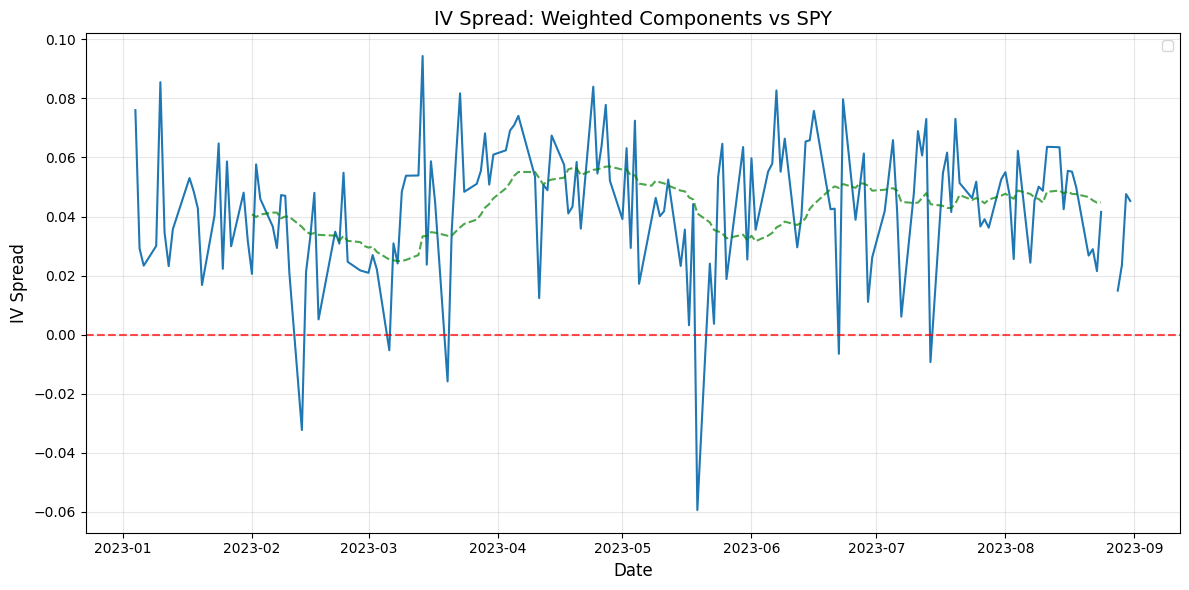

IV Spread Statistics:
Mean: 0.0430
Std: 0.0224
Min: -0.0594
Max: 0.0944


In [ ]:
import matplotlib.pyplot as plt

# Plot the IV spread over time
plt.figure(figsize=(12, 6))
plt.plot(iv_comparison['date'], iv_comparison['IV_Spread'], linewidth=1.5)
plt.title('IV Spread: Weighted Components vs SPY', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('IV Spread', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Calculate rolling mean of IV_Spread with 20-day window
iv_comparison['IV_Spread_Rolling_20'] = iv_comparison['IV_Spread'].rolling(window=20).mean()

mean_spread = iv_comparison['IV_Spread_Rolling_20']
plt.plot(mean_spread, color='green', linestyle='--', alpha=0.7)

plt.legend()
plt.tight_layout()
plt.show()

print(f"IV Spread Statistics:")
print(f"Mean: {iv_comparison['IV_Spread'].mean():.4f}")
print(f"Std: {iv_comparison['IV_Spread'].std():.4f}")
print(f"Min: {iv_comparison['IV_Spread'].min():.4f}")
print(f"Max: {iv_comparison['IV_Spread'].max():.4f}")

<Axes: ylabel='Frequency'>

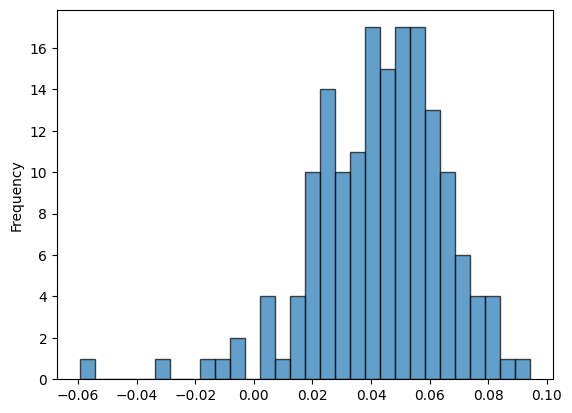

In [ ]:
iv_comparison['IV_Spread'].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)

In [ ]:
# Backtest dispersion trading strategy with actual option positions
# Short 5 SPY straddles, Long component ETF straddles based on weight_mapping

# Initialize strategy variables
iv_comparison = iv_comparison.copy()
iv_comparison['position'] = 0  # 0 = no position, 1 = long spread
iv_comparison['entry_signal'] = False
iv_comparison['exit_signal'] = False
iv_comparison['pnl'] = 0.0
iv_comparison['cumulative_pnl'] = 0.0
iv_comparison['entry_cost'] = 0.0

# Strategy logic
position = 0
entry_prices = {}
total_pnl = 0

for i in range(len(iv_comparison)):
    current_spread = iv_comparison.iloc[i]['IV_Spread']
    rolling_mean = iv_comparison.iloc[i]['IV_Spread_Rolling_20']
    current_date = iv_comparison.iloc[i]['date']
    
    # Entry condition: buy when spread <= 0 and no current position
    if current_spread <= 0 and position == 0:
        position = 1
        
        # Get option prices for entry
        current_atm = atm_options[atm_options['date'] == current_date]
        
        if len(current_atm) > 0:
            # Entry prices (what we pay/receive)
            entry_prices = {}
            total_entry_cost = 0
            
            # Short 5 SPY straddles (receive premium)
            spy_options = current_atm[current_atm['ticker'] == 'SPY']
            if len(spy_options) > 0:
                spy_premium = spy_options['best_bid'].mean() * 5  # 5 contracts
                entry_prices['SPY'] = spy_premium
                total_entry_cost += spy_premium  # Positive because we receive premium
            
            # Long component ETF straddles based on weight_mapping
            for ticker in ['XLK', 'XLY', 'XLF', 'XLV']:
                etf_options = current_atm[current_atm['ticker'] == ticker]
                if len(etf_options) > 0 and ticker in weight_mapping:
                    contracts = weight_mapping[ticker]
                    etf_premium = etf_options['best_offer'].mean() * contracts
                    entry_prices[ticker] = etf_premium
                    total_entry_cost -= etf_premium  # Negative because we pay premium
        
        iv_comparison.iloc[i, iv_comparison.columns.get_loc('position')] = 1
        iv_comparison.iloc[i, iv_comparison.columns.get_loc('entry_signal')] = True
        iv_comparison.iloc[i, iv_comparison.columns.get_loc('entry_cost')] = total_entry_cost
    
    # Exit condition: sell when spread > rolling mean and have position
    elif position == 1 and not pd.isna(rolling_mean) and current_spread > rolling_mean:
        position = 0
        
        # Calculate P&L from option positions
        current_atm = atm_options[atm_options['date'] == current_date]
        trade_pnl = 0
        
        if len(current_atm) > 0 and entry_prices:
            # Close SPY short position (pay to buy back)
            spy_options = current_atm[current_atm['ticker'] == 'SPY']
            if len(spy_options) > 0 and 'SPY' in entry_prices:
                spy_exit = spy_options['best_offer'].mean() * 5
                spy_pnl = entry_prices['SPY'] - spy_exit  # Received - Paid
                trade_pnl += spy_pnl
            
            # Close long ETF positions (sell)
            for ticker in ['XLK', 'XLY', 'XLF', 'XLV']:
                etf_options = current_atm[current_atm['ticker'] == ticker]
                if len(etf_options) > 0 and ticker in entry_prices and ticker in weight_mapping:
                    contracts = weight_mapping[ticker]
                    etf_exit = etf_options['best_bid'].mean() * contracts
                    etf_pnl = etf_exit - entry_prices[ticker]  # Received - Paid
                    trade_pnl += etf_pnl
        
        total_pnl += trade_pnl
        iv_comparison.iloc[i, iv_comparison.columns.get_loc('position')] = 0
        iv_comparison.iloc[i, iv_comparison.columns.get_loc('exit_signal')] = True
        iv_comparison.iloc[i, iv_comparison.columns.get_loc('pnl')] = trade_pnl
        
        entry_prices = {}  # Reset for next trade
    
    # Maintain position
    elif position == 1:
        iv_comparison.iloc[i, iv_comparison.columns.get_loc('position')] = 1
    
    iv_comparison.iloc[i, iv_comparison.columns.get_loc('cumulative_pnl')] = total_pnl

# Calculate strategy statistics
trades = iv_comparison[iv_comparison['exit_signal'] == True]
num_trades = len(trades)
win_trades = trades[trades['pnl'] > 0]
win_rate = len(win_trades) / num_trades if num_trades > 0 else 0

print("=== Dispersion Trading Strategy Backtest Results ===")
print(f"Positions: Short 5 SPY straddles, Long ETF straddles per weight_mapping: {weight_mapping}")
print(f"Total P&L: ${total_pnl:.2f}")
print(f"Number of trades: {num_trades}")
print(f"Win rate: {win_rate:.2%}")
print(f"Average P&L per trade: ${trades['pnl'].mean():.2f}" if num_trades > 0 else "No trades")
print(f"Best trade: ${trades['pnl'].max():.2f}" if num_trades > 0 else "No trades")
print(f"Worst trade: ${trades['pnl'].min():.2f}" if num_trades > 0 else "No trades")

# Show entry costs for trades
entries = iv_comparison[iv_comparison['entry_signal'] == True]
if len(entries) > 0:
    print(f"\nAverage entry cost: ${entries['entry_cost'].mean():.2f}")
    print(f"Entry cost statistics:")
    print(f"Min: ${entries['entry_cost'].min():.2f}")
    print(f"Max: ${entries['entry_cost'].max():.2f}")

=== Dispersion Trading Strategy Backtest Results ===
Positions: Short 5 SPY straddles, Long ETF straddles per weight_mapping: {'SPY': 5, 'XLV': 2, 'XLY': 2, 'XLF': 8, 'XLK': 7}
Total P&L: $294.25
Number of trades: 6
Win rate: 66.67%
Average P&L per trade: $49.04
Best trade: $180.13
Worst trade: $-54.57

Average entry cost: $22.93
Entry cost statistics:
Min: $-37.86
Max: $140.34


In [ ]:
import yfinance as yf

opt = yf.Ticker("XLF").option_chain("2025-08-22")
print(opt.calls.head())

       contractSymbol             lastTradeDate  strike  lastPrice  bid  ask  \
0  XLF250822C00046500 2025-07-15 13:30:00+00:00    46.5       6.22  0.0  0.0   
1  XLF250822C00047000 2025-07-21 18:44:24+00:00    47.0       6.03  0.0  0.0   
2  XLF250822C00047500 2025-07-21 18:44:24+00:00    47.5       5.55  0.0  0.0   
3  XLF250822C00048000 2025-07-15 14:28:25+00:00    48.0       4.55  0.0  0.0   
4  XLF250822C00049000 2025-07-25 20:01:51+00:00    49.0       4.67  0.0  0.0   

   change  percentChange  volume  openInterest  impliedVolatility  inTheMoney  \
0     0.0            0.0     NaN             1            0.00001        True   
1     0.0            0.0     NaN             1            0.00001        True   
2     0.0            0.0     NaN             1            0.00001        True   
3     0.0            0.0     NaN             4            0.00001        True   
4     0.0            0.0     2.0             1            0.00001        True   

  contractSize currency  
0     